# End-to-End Tweet Sentiment Analysis

The notebook walks us through the step-by-step process of performing sentiment analysis using Python.

The Twitter Data contains the following 4 fields:
1. __textID -__ unique ID for each piece of text
2. __text -__ the text of the tweet
3. __sentiment -__ the general sentiment of the tweet (negative, neutral, positive)
4. __selected_text -__ [train only] the text that supports the tweet's sentiment

## Step 1: Importing Libraries

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import re
import string

# methods and stopwords text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# machine learning libraries
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# visualization
import matplotlib.pyplot as plt

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

English Stopwords

In [3]:
# creating a stopwords set
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\basit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 2: Preprocessing the Tweet Text

We shall perform the following transformations on the raw tweets:
1. Casing
2. Noise Removal
3. Tokenization
4. Stopword Removal
5. Text Normalization (Stemming and Lemmatization)

In [4]:
def preprocess_tweet(tweet):
    """
    Runs a set of transformational steps to
    preprocess the text of the tweet.
    """
    # convert all text to lower case
    tweet = tweet.lower()

    # remove any urls
    tweet  = re.sub(r'http\S+|www\S+|https\S+', "", tweet, flags=re.MULTILINE)
    
    # replace '****' with 'curse'
    tweet = re.sub(r'\*\*\*\*', "gaali", tweet)

    # remove punctuations
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))

    # remove user @ references and hashtags
    tweet = re.sub(r'\@\w+|\#', "", tweet)
    
    # remove useless characters
    tweet = re.sub(r'[^ -~]', '', tweet)

    # remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stop_words]

    # stemming
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]

    # lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]

    return ' '.join(lemma_words)

In [5]:
# downloading the additional resources required by nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\basit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\basit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\basit\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
# an example of the preprocessing
print(preprocess_tweet("Hi I am Haris Javed"))

hi hari jave


In [7]:
# Loading the tweets dataset
tweets_ds = pd.read_csv('data/train.csv')
tweets_ds_test = pd.read_csv('data/test.csv')

In [8]:
# viewing the dataset head
tweets_ds

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [9]:
# removing the records with null values
tweets_ds = tweets_ds.dropna(axis=0)
tweets_ds.reset_index(drop=True, inplace=True)
tweets_ds[:315]

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
310,5b578d0b4c,"Just opened a facebook account, I`m a little c...",better,positive
311,c4ab28566e,Ship. I`m stuck.,Ship. I`m stuck.,negative
312,162a2510d2,DUSTBIN BABY ON AT 11.30 Cannot wait x,Cannot wait,positive
313,c25871ec9e,"Not going to dwell on it. It happened, it`s p...",shame,negative


In [10]:
# preprocessing the tweets in the dataset
protw = [] # stores the processed tweet of each record
for i in range(0, len(tweets_ds)):
    protw.append(preprocess_tweet(tweets_ds.text[i]))

In [11]:
# adding a new column which holds the processed tweet for each record
tweets_ds['processed_tweet'] = protw
tweets_ds

C:\Users\basit\AppData\Local\Temp\ipykernel_22020\2389535132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_ds['processed_tweet'] = protw


,textID,text,selected_text,sentiment,processed_tweet
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bulli
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leav alon
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son gaali couldnt put releas alreadi bought
...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish could come see u denver husband lost job ...
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,ive wonder rake client made clear net dont for...
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good enjoy break probabl need hectic weeke...
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,worth gaali


In [12]:
# preprocessing the tweets in the dataset
protw = [] # stores the processed tweet of each record
for i in range(0, len(tweets_ds_test)):
    protw.append(preprocess_tweet(tweets_ds_test.text[i]))

In [13]:
# adding a new column which holds the processed tweet for each record
tweets_ds_test['processed_tweet'] = protw
tweets_ds_test

,textID,text,sentiment,processed_tweet
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai also realli excit precis skyscrap gal...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recess hit veroniqu branquinho quit compani shame
3,01082688c6,happy bday!,positive,happi bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,like
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,3 im tire cant sleep tri
3530,416863ce47,All alone in this old house again. Thanks for...,positive,alon old hous thank net keep aliv kick whoever...
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,know mean littl dog sink depress want move som...
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,sutra next youtub video gon na love video


## Step 3: Modelling

Splitting the dataset into training and testing datasets

In [14]:
X = tweets_ds.drop('sentiment', axis=1)
y_train = tweets_ds.sentiment

In [15]:
y_test = tweets_ds_test.sentiment

Vectorizing the tweets

In [16]:
# instantiate the vectorizer object
tv = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')

In [17]:
# tweets for training are vectorized first
tv.fit(X.processed_tweet)
X_train = tv.transform(X.processed_tweet)
X_train

<27480x7949 sparse matrix of type '<class 'numpy.int64'>'
	with 157112 stored elements in Compressed Sparse Row format>

In [18]:
# test tweeets are now vectorized
X_test = tv.transform(tweets_ds_test.processed_tweet)
X_test

<3534x7949 sparse matrix of type '<class 'numpy.int64'>'
	with 19350 stored elements in Compressed Sparse Row format>

Testing different models

In [19]:
# Function to fit and score the models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: testing labels
    """
    
    # Set up random seed
    np.random.seed(42)
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its scores to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [20]:
# Putting models in a dictionary
models = {'Random Forest Classifier': RandomForestClassifier(),
          'Logistic Regression': LogisticRegression(),
          'Support Vector Classifier': SVC()}

In [21]:
%%notify
# Scoring the models
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Random Forest Classifier': 0.702037351443124,
 'Logistic Regression': 0.7040181097906055,
 'Support Vector Classifier': 0.7133559705715903}

<IPython.core.display.Javascript object>

Since `LogisticRegression` turned out to be the model with the best raw score (roughly 95%), we shall proceed to tune its hyperparameters.

## Step 4: Hyperparameter Tuning

Let us find the roughly the best hyperparameters of the `RandomForestClassifier` model using `Optuna`.

In [21]:
import optuna
import sklearn

In [22]:
# the objective function is used by optuna to tune the hyperparameters
def objective(trial):
    # on each trial, a value is suggested for each of the defined hyperparameters
    # the values are then used to train the model and its score is evaluated
    n_estimators = int(trial.suggest_float('n_estimators', 200, 2000, step=10))
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_depth = int(trial.suggest_float('max_depth', 10, 1000, step=10))
    min_samples_split = int(trial.suggest_float('min_samples_split', 2, 14, step=3))
    min_samples_leaf = int(trial.suggest_float('min_samples_leaf', 1, 8, step=2))
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    
    # instantiating the model with the selected hyperparameters
    rfc = RandomForestClassifier(n_estimators=n_estimators,
                                 max_features=max_features,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 criterion=criterion,
                                 n_jobs=-1)

    # returning the mean of the cross-validation score of the model
    return sklearn.model_selection.cross_val_score(
        rfc, X_train, y_train, n_jobs=-1, cv=3).mean()

In [23]:
# # the objective function is used by optuna to tune the hyperparameters
# def objective(trial):
#     # on each trial, a value is suggested for each of the defined hyperparameters
#     # the values are then used to train the model and its score is evaluated
#     logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
    
# #     C = trial.suggest_float('C', 1, 1000, log=True)
# #     solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
# #     penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
#     max_iter = int(trial.suggest_float('max_iter', 100, 5000))
    
#     # instantiating the model with the selected hyperparameters
#     lgr = LogisticRegression(C=logreg_c,
#                              max_iter=max_iter)

#     # returning the mean of the cross-validation score of the model
#     return sklearn.model_selection.cross_val_score(
#         lgr, X_train, y_train, n_jobs=-1, cv=3).mean()

In [24]:
# # the objective function is used by optuna to tune the hyperparameters
# def objective(trial):
#     # on each trial, a value is suggested for each of the defined hyperparameters
#     # the values are then used to train the model and its score is evaluated
#     _c = trial.suggest_float('c', 1e-10, 1e10, log=True)
#     _degree = trial.suggest_float('degree', 1, 100)
#     _kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
#     _gamma = trial.suggest_categorical("gamma", ["auto", "scale"])
#     _decision_function_shape = trial.suggest_categorical("decision_function_shape", ["ovo", "ovr"])
# #     c.append(_c)
# #     degree.append(_degree)
# #     kernel.append(_kernel)
# #     gamma.append(_gamma)
# #     decision_function_shape.append(_decision_function_shape)
# #     print("Trial Parameters:")
# #     print(_c)
# #     print(_degree)
# #     print(_kernel)    
# #     print(_gamma)
# #     print(_decision_function_shape)
    

#     # instantiating the model with the selected hyperparameters
#     svc = SVC(C=_c,
#               degree=_degree,
#               kernel=_kernel,
#               gamma=_gamma,
#               decision_function_shape=_decision_function_shape)
#     svc.fit(X_train, y_train)

#     # returning the mean of the cross-validation score of the model
#     return svc.score(X_test, y_test)

In [25]:
%%notify
decision_function_shape = []
# the goal is to maximize the accuracy, hence the direction
study = optuna.create_study(direction='maximize')
# we will perform 100 trials
study.optimize(objective, n_trials=100)

# retrieving the best trial
trial = study.best_trial
# Displaying outputs
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-09-24 13:33:14,899] A new study created in memory with name: no-name-633b8e6c-13a5-49d7-874a-750cbea2a419
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7.0].
  warnings.warn(
[I 2022-09-24 13:36:41,070] Trial 0 finished with value: 0.6938864628820961 and parameters: {'n_estimators': 740.0, 'max_features': 'log2', 'max_depth': 610.0, 'min_samples_split': 8.0, 'min_samples_leaf': 1.0, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.6938864628820961.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7.0].
  warnings.warn(
[I 2022-09-24 13:38:09,259] Trial 1 finished with value: 0.6969432314410481 a

[I 2022-09-24 14:03:50,944] Trial 14 finished with value: 0.7096433770014556 and parameters: {'n_estimators': 1260.0, 'max_features': 'sqrt', 'max_depth': 960.0, 'min_samples_split': 11.0, 'min_samples_leaf': 3.0, 'criterion': 'gini'}. Best is trial 14 with value: 0.7096433770014556.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7.0].
  warnings.warn(
[I 2022-09-24 14:07:19,536] Trial 15 finished with value: 0.7097161572052402 and parameters: {'n_estimators': 1520.0, 'max_features': 'auto', 'max_depth': 980.0, 'min_samples_split': 11.0, 'min_samples_leaf': 3.0, 'criterion': 'gini'}. Best is trial 15 with value: 0.7097161572052402.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2

[I 2022-09-24 15:04:16,256] Trial 29 finished with value: 0.7084061135371179 and parameters: {'n_estimators': 1430.0, 'max_features': 'auto', 'max_depth': 760.0, 'min_samples_split': 8.0, 'min_samples_leaf': 1.0, 'criterion': 'log_loss'}. Best is trial 16 with value: 0.7117176128093159.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7.0].
  warnings.warn(
[I 2022-09-24 15:05:09,036] Trial 30 finished with value: 0.7086972343522562 and parameters: {'n_estimators': 1780.0, 'max_features': 'auto', 'max_depth': 890.0, 'min_samples_split': 5.0, 'min_samples_leaf': 3.0, 'criterion': 'log_loss'}. Best is trial 16 with value: 0.7117176128093159.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and 

[I 2022-09-24 15:31:29,568] Trial 44 finished with value: 0.7102256186317323 and parameters: {'n_estimators': 1230.0, 'max_features': 'auto', 'max_depth': 450.0, 'min_samples_split': 8.0, 'min_samples_leaf': 1.0, 'criterion': 'gini'}. Best is trial 33 with value: 0.7119723435225618.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7.0].
  warnings.warn(
[I 2022-09-24 15:32:19,771] Trial 45 finished with value: 0.7093522561863174 and parameters: {'n_estimators': 1870.0, 'max_features': 'auto', 'max_depth': 920.0, 'min_samples_split': 8.0, 'min_samples_leaf': 3.0, 'criterion': 'gini'}. Best is trial 33 with value: 0.7119723435225618.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, 

[I 2022-09-24 15:56:47,905] Trial 59 finished with value: 0.7115356622998544 and parameters: {'n_estimators': 1940.0, 'max_features': 'sqrt', 'max_depth': 560.0, 'min_samples_split': 14.0, 'min_samples_leaf': 1.0, 'criterion': 'gini'}. Best is trial 58 with value: 0.7129184861717613.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7.0].
  warnings.warn(
[I 2022-09-24 15:59:01,812] Trial 60 finished with value: 0.7122270742358078 and parameters: {'n_estimators': 1990.0, 'max_features': 'sqrt', 'max_depth': 680.0, 'min_samples_split': 14.0, 'min_samples_leaf': 1.0, 'criterion': 'gini'}. Best is trial 58 with value: 0.7129184861717613.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2

[I 2022-09-24 16:32:48,866] Trial 74 finished with value: 0.7114992721979622 and parameters: {'n_estimators': 1940.0, 'max_features': 'sqrt', 'max_depth': 470.0, 'min_samples_split': 14.0, 'min_samples_leaf': 1.0, 'criterion': 'gini'}. Best is trial 64 with value: 0.7131732168850072.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7.0].
  warnings.warn(
[I 2022-09-24 16:35:28,350] Trial 75 finished with value: 0.7113537117903931 and parameters: {'n_estimators': 520.0, 'max_features': 'sqrt', 'max_depth': 630.0, 'min_samples_split': 14.0, 'min_samples_leaf': 1.0, 'criterion': 'gini'}. Best is trial 64 with value: 0.7131732168850072.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2,

[I 2022-09-24 18:25:14,197] Trial 89 finished with value: 0.713027656477438 and parameters: {'n_estimators': 1850.0, 'max_features': 'sqrt', 'max_depth': 730.0, 'min_samples_split': 14.0, 'min_samples_leaf': 1.0, 'criterion': 'gini'}. Best is trial 64 with value: 0.7131732168850072.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7.0].
  warnings.warn(
[I 2022-09-24 18:35:16,496] Trial 90 finished with value: 0.7117176128093158 and parameters: {'n_estimators': 1840.0, 'max_features': 'sqrt', 'max_depth': 600.0, 'min_samples_split': 11.0, 'min_samples_leaf': 1.0, 'criterion': 'gini'}. Best is trial 64 with value: 0.7131732168850072.
D:\Machine Learning Projects\tweet_sentiment_analysis\env\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1, 8] and step=2,

Accuracy: 0.7131732168850072
Best hyperparameters: {'n_estimators': 1910.0, 'max_features': 'sqrt', 'max_depth': 740.0, 'min_samples_split': 14.0, 'min_samples_leaf': 1.0, 'criterion': 'gini'}


<IPython.core.display.Javascript object>

The tuning on `LogisticRegression` gave us the accuracy of 0.6916666666666668 with the best parameters being:

{
'logreg_c': 0.31430173665858063, 

'max_iter': 4230.062049823412
}

The tuning on `RandomForestClassifier` gave us the accuracy of 0.7131732168850072 with the best parameters being:

{
'n_estimators': 1910.0,

'max_features': 'sqrt',

'max_depth': 740.0, 

'min_samples_split': 14.0, 

'min_samples_leaf': 1.0, 

'criterion': 'gini'
}

Unfortunately, I was unable to perform the tuning on `SupportVectorClassifier` as it would not proceed beyond a trial or two for some unknown reason. Will have to check back on this later.

Let us test our newly found tuned hyperparameters for `RandomForestClassifier`.

In [25]:
rfc = RandomForestClassifier(n_estimators=1910,
                             max_features='sqrt',
                             max_depth=740,
                             min_samples_split=14,
                             min_samples_leaf=1,
                             criterion='gini',
                             n_jobs=-1)

In [26]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=740, min_samples_split=14, n_estimators=1910,
                       n_jobs=3)

In [27]:
rfc.score(X_test, y_test)

0.7232597623089984

Great! Our model saw an increase of roughly 2% in accuracy with the tuned hyperparameters.

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [740],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [12, 13, 14, 15, 16],
    'n_estimators': [1710, 1810, 1910, 2010, 2110]
}
param_grid

{'criterion': ['gini'],
 'max_depth': [740],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 3, 5],
 'min_samples_split': [12, 13, 14, 15, 16],
 'n_estimators': [1710, 1810, 1910, 2010, 2110]}

In [30]:
%%notify
rfc = RandomForestClassifier()
gs = GridSearchCV(rfc, param_grid, cv=5, n_jobs=8, verbose=2)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'criterion': ['gini'], 'max_depth': [740],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [12, 13, 14, 15, 16],
                         'n_estimators': [1710, 1810, 1910, 2010, 2110]},
             verbose=2)

<IPython.core.display.Javascript object>

In [31]:
rfc_gs = gs.best_estimator_

In [33]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 740,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 1810}

Let us test the hyperparameters obtained from `GridSearchCV`.

In [30]:
rfc = RandomForestClassifier(n_estimators=1810,
                             max_features='sqrt',
                             max_depth=740,
                             min_samples_split=15,
                             min_samples_leaf=1,
                             criterion='gini',
                             n_jobs=-1)

In [33]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=740, min_samples_split=15, n_estimators=1810,
                       n_jobs=-1)

In [34]:
rfc.score(X_test, y_test)

0.7243916242218449

It seems the tuning resulted in an increase of `0.0011318619128465` in accuracy. Not a lot, but we'll go for it.

So for now we will stick with the `GridSearchCV` tuned model.

## Step 5: Evaluating a classification model, beyond accuracy

Now we've got a tuned model, let's get some of the metrics we discussed before.

We want:
* Confusion matrix - [`confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
* Classification report - [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
* Precision - [`precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* Recall - [`recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
* F1-score - [`f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

Luckily, Scikit-Learn has these all built-in.

To access them, we'll have to use our model to make predictions on the test set. You can make predictions by calling `predict()` on a trained model and passing it the data you'd like to predict on.

We'll make predictions on the test data.

In [39]:
rfc = RandomForestClassifier(n_estimators=1810,
                             max_features='sqrt',
                             max_depth=740,
                             min_samples_split=15,
                             min_samples_leaf=1,
                             criterion='gini',
                             n_jobs=-1)

In [40]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=740, min_samples_split=15, n_estimators=1810,
                       n_jobs=-1)

In [41]:
# Make preidctions on test data
y_preds = rfc.predict(X_test)
y_preds

array(['neutral', 'positive', 'negative', ..., 'negative', 'positive',
       'positive'], dtype=object)

They look like our original test data labels, except different where the model has predicted wrong.

In [42]:
y_test

0        neutral
1       positive
2       negative
3       positive
4       positive
          ...   
3529    negative
3530    positive
3531    negative
3532    positive
3533    positive
Name: sentiment, Length: 3534, dtype: object

Since we've got our prediction values we can find the metrics we want.

Let's start with the Confusion Matrix.

### Confusion matrix 

A confusion matrix is a visual way to show where your model made the right predictions and where it made the wrong predictions (or in other words, got confused).

Scikit-Learn allows us to create a confusion matrix using [`confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and passing it the true labels and predicted labels.

In [44]:
# Display confusion matrix
print(confusion_matrix(y_test, y_preds))

[[ 665  266   70]
 [ 201 1029  200]
 [  34  211  858]]


As you can see, Scikit-Learn's built-in confusion matrix is a bit bland. For a presentation you'd probably want to make it visual.

Let's create a function which uses Seaborn's [`heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for doing so.

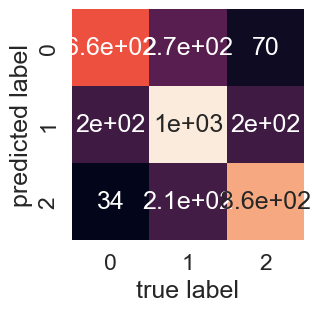

In [47]:
# Import Seaborn
import seaborn as sns
sns.set(font_scale=1.5) # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_preds)

Beautiful! That looks much better. 

### Classification report

We can make a classification report using [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and passing it the true labels as well as our models predicted labels. 

A classification report will also give us information of the precision and recall of our model for each class.

In [49]:
from sklearn.metrics import classification_report

In [50]:
# Show classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

    negative       0.74      0.66      0.70      1001
     neutral       0.68      0.72      0.70      1430
    positive       0.76      0.78      0.77      1103

    accuracy                           0.72      3534
   macro avg       0.73      0.72      0.72      3534
weighted avg       0.72      0.72      0.72      3534



Ok, now we've got a few deeper insights on our model. But these were all calculated using a single training and test set.

What we'll do to make them more solid is calculate them using cross-validation.

How?

We'll take the best model along with the best hyperparameters and use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) along with various `scoring` parameter values.

`cross_val_score()` works by taking an estimator (machine learning model) along with data and labels. It then evaluates the machine learning model on the data and labels using cross-validation and a defined `scoring` parameter.

In [51]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score

Now we've already got an instantiated classifier, let's find some cross-validated metrics.

In [54]:
# Cross-validated accuracy score
cv_acc = cross_val_score(rfc,
                         X_train,
                         y_train,
                         cv=5, # 5-fold cross-validation
                         scoring="accuracy") # accuracy as scoring
cv_acc

array([0.70924309, 0.71306405, 0.72016012, 0.70705968, 0.72052402])

Since there are 5 metrics here, we'll take the average.

In [55]:
cv_acc = np.mean(cv_acc)
cv_acc

0.71401018922853

Now we'll do the same for other classification metrics.

In [59]:
# Cross-validated precision score
cv_precision = np.mean(cross_val_score(rfc,
                                       X_train,
                                       y_train,
                                       cv=5, # 5-fold cross-validation
                                       scoring="precision_macro")) # precision as scoring
cv_precision

0.7210606608581174

In [60]:
# Cross-validated recall score
cv_recall = np.mean(cross_val_score(rfc,
                                    X_train,
                                    y_train,
                                    cv=5, # 5-fold cross-validation
                                    scoring="recall_macro",
                                    n_jobs=-1)) # recall as scoring
cv_recall

0.7099888783528091

In [61]:
# Cross-validated F1 score
cv_f1 = np.mean(cross_val_score(rfc,
                                X_train,
                                y_train,
                                cv=5, # 5-fold cross-validation
                                scoring="f1_macro",
                                n_jobs=-1)) # f1 as scoring
cv_f1

0.7133143072276928

Okay, we've got cross validated metrics, now what?

Let's visualize them.

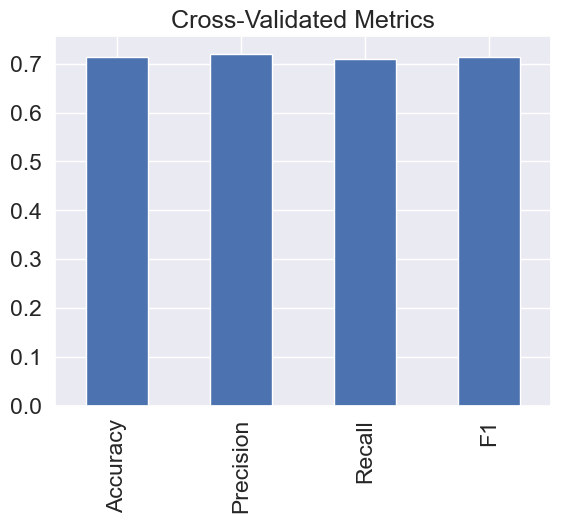

In [62]:
# Visualizing cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);

Great! This looks like something we could share. An extension might be adding the metrics on top of each bar so someone can quickly tell what they were.

## Saving the Model and Transformer

Let's save the model we just created for future use.

In [34]:
import joblib

In [30]:
joblib.dump(rfc, 'models/model_v1.pkl', compress=3)

['models/model_v1.pkl']

In [35]:
joblib.dump(tv, 'models/transformer_v1.pkl')

['models/transformer_v2.pkl']